# Use case: masked arrays, multi-band photometry

We want to build color profiles by running `ellipse` on an image, and then, using the isophotes so derived, to get isophotes on another image of the same object in a different spectral band.

In this example we use public domain images of NGC1068 from the Hubble Space Telescope archive (https://www.spacetelescope.org/projects/fits_liberator/ngc1068data/). 

One of them is a wide-band ~R image, the other is a narrow-band H$\alpha$ + [NII]. Due to the detector shapes, the image frames do not contain meaningful information everywhere; some regions have to be masked out. The `isophote` package can handle numpy masked arrays, thus we build masked image frames before submitting then for analysis.

Note that the use of masked arrays slows down the computations by a significant amount.

We use the higher S/N wide band image to fit the isophotes; then, loop over the geometry of these isophotes to extract samples from the narrow-band, lower S/N image, without fitting. This should minimize fitting problems caused by the lumpiness and lower S/N of the narrow-band image. 

This notebook presents a more advanced used of the `isophote` package. If you didn't read the other notebboks and are not familiar with this kind of analysis, we recommend you do so before tackling this script. 

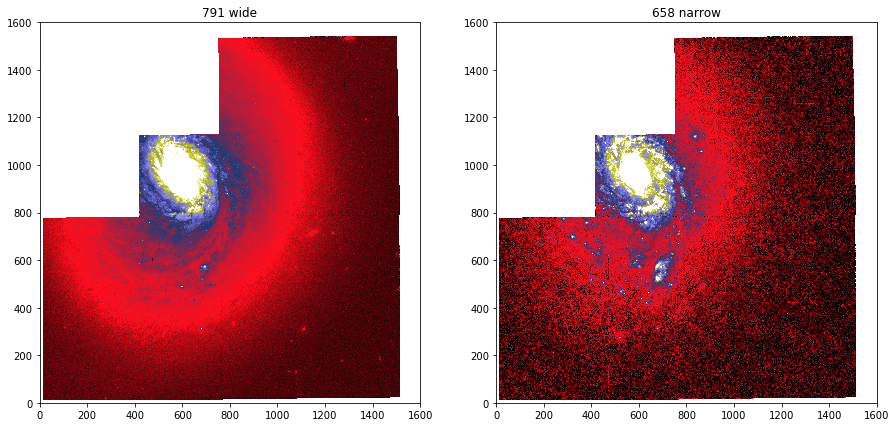

In [1]:
from astropy.io import fits
from astropy.utils.data import download_file

# This was copied from the astropy-tutorials/Contributing.md file,
# but doesn't work (generates a 'unknown url' error).
# tutorialpath = ''
# 791wmos = download_file(tutorialpath + '791wmos.fits', cache=True)
# image = fits.open(791wmos)
image = fits.open('791wmos.fits')
pixel_data_791 = image[0].data
image = fits.open('658nmos.fits')
pixel_data_658 = image[0].data

# build masked arrays to remove invalid pixels
import numpy as np
import numpy.ma as ma
pixel_data_658 = ma.masked_equal(pixel_data_658, np.zeros(shape=pixel_data_658.shape))
pixel_data_791 = ma.masked_equal(pixel_data_791, np.zeros(shape=pixel_data_791.shape))

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
limits = [0,1600]
ax1.imshow(pixel_data_791, cmap=cm.gist_stern, vmin=0, vmax=400)
ax1.set_xlim(limits)
ax1.set_ylim(limits)
ax1.set_title("791 wide")
ax2.imshow(pixel_data_658, cmap=cm.gist_stern, vmin=0, vmax=50)
ax2.set_xlim(limits)
ax2.set_ylim(limits)
ax2.set_title("658 narrow")

### 1 - Fit isophotes on wide-band image

In [2]:
from photutils.isophote.geometry import Geometry
from photutils.isophote.ellipse import Ellipse
# firts guess geometry
x0 = 600.    # center position
y0 = 970.    # center porsition
sma = 100.   # semi-major axis length in pixels
eps = 0.3    # ellipticity
pa = 120. / 180. * np.pi # position angle

g = Geometry(x0, y0, sma, eps, pa)
ellipse = Ellipse(pixel_data_791, geometry=g)

Centering on object....   Done. Found x0 = 605.0, y0 = 965.0


In [3]:
w_list = ellipse.fit_image(integrmode='median',maxsma=400.,fflag=0.3,sclip=3.0,nclip=3)

#
# Semi-      Isophote         Ellipticity    Position     Grad.   Data  Flag Iter. Stop
# major        mean                           Angle        rel.                    code
# axis       intensity                                    error
#(pixel)                                     (degree)
#
 100.00      505.30 ( 6.75)  0.383 (0.002) 110.24 ( 0.2)  0.135   105     1   20     0
 110.00      466.60 ( 6.66)  0.405 (0.002) 110.24 ( 0.2)  0.123   107     1   10     0
 121.00      377.67 ( 4.95)  0.333 (0.003) 127.48 ( 0.3)  0.141   120     2   10     0
 133.10      361.26 ( 3.50)  0.390 (0.002) 128.14 ( 0.1)  0.112   115     4   10     0
 146.41      290.61 ( 3.72)  0.320 (0.002) 125.42 ( 0.2)  0.086   124     3   10     0
 161.05      237.69 ( 3.21)  0.319 (0.001) 127.49 ( 0.1)  0.074   127     0   10     0
 177.16      194.96 ( 3.06)  0.341 (0.001) 129.03 ( 0.1)  0.063   119     8   10     0
 194.87      142.93 ( 2.33)  0.350 (0.002) 126.40 ( 0.2)  0.115   112    15   10     0
 214.3

/Users/busko/Projects/miniconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/busko/Projects/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/busko/Projects/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/busko/Projects/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/busko/Projects/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


@@@@@@     line: 230  - 
   0.70    12662.62 (225.18)  0.383 (894.289) 110.24 (88417.5)  None     13     0   12     5
@@@@@@     line: 239  -  -8127.29912207 24594.9990197
   0.64    12687.00 (213.94)  0.383 (0.430) 110.24 (42.5)  79.173    13     0    1     5
@@@@@@     line: 230  - 
   0.58    12664.62 (187.13)  0.383 (976.851) 110.24 (96580.7)  None     13     0   15     5
@@@@@@     line: 239  -  -6620.42192303 20508.2489073
   0.53    12688.74 (179.65)  0.383 (1.840) 110.24 (181.9)  326.480    13     0    1     5
   0.00    12651.71


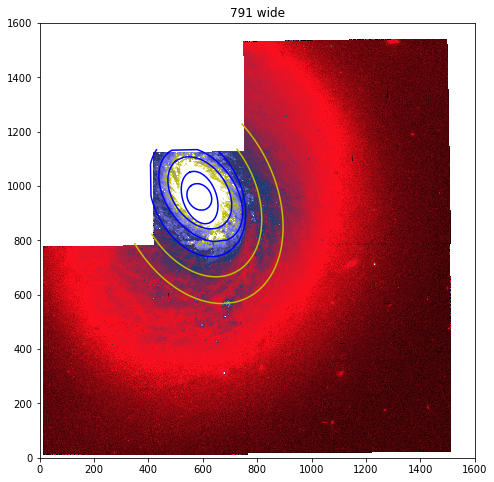

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(pixel_data_791, cmap=cm.gist_stern, vmin=0, vmax=400)
ax.set_xlim(limits)
ax.set_ylim(limits)
ax.set_title("791 wide")

for sma in [50.,100.,150.,200.,235.]:
    iso = w_list.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    plt.plot(x, y, color='blue')
for sma in [300.,400.]:
    iso = w_list.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    plt.plot(x, y, color='y')

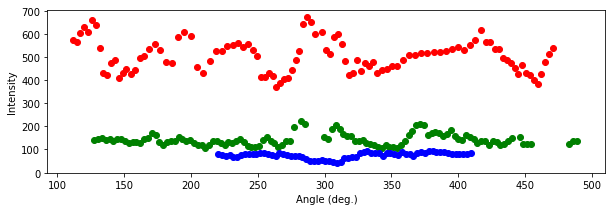

In [32]:
plt.figure(figsize=(10, 3))
plt.ylabel("Intensity")
plt.xlabel("Angle (deg.)")
for sma,color in zip([100.,200.,300.],['r','g','b']):
    iso = w_list.get_closest(sma)
    plt.scatter((iso.sample.values[0]+iso.sample.geometry.pa)/np.pi*180., iso.sample.values[2], color=color)

In [10]:
x0 = 600. 
y0 = 970.
sma = 300.
eps = 0.2
pa = 70. / 180. * np.pi
g = Geometry(x0, y0, sma, eps, pa)
ellipse = Ellipse(pixel_data_791, geometry=g)
w_list_outer = ellipse.fit_image(integrmode='median',step=0.3,minsma=300.,maxsma=700.,fflag=0.3,sclip=3.0,nclip=3)

Centering on object....   Done. Found x0 = 605.0, y0 = 965.0
#
# Semi-      Isophote         Ellipticity    Position     Grad.   Data  Flag Iter. Stop
# major        mean                           Angle        rel.                    code
# axis       intensity                                    error
#(pixel)                                     (degree)
#
 300.00       58.37 ( 0.77)  0.094 (0.032)  46.42 ( 2.9)  0.174    79    48   20     0
 390.00       44.24 ( 0.62)  0.094 (0.004)  94.86 ( 3.6)  0.124    81    46   10     0
 507.00       35.96 ( 0.38)  0.201 (0.004)  86.23 ( 1.5)  0.078    78    49   10     0
 659.10       18.85 ( 0.07)  0.201 (0.001)  66.12 ( 0.2)  0.035    80    47   10     0
 230.77     1131.15 (99.14)  0.950 (0.009)  90.20 ( 0.6)  4.845    37     1   10     0


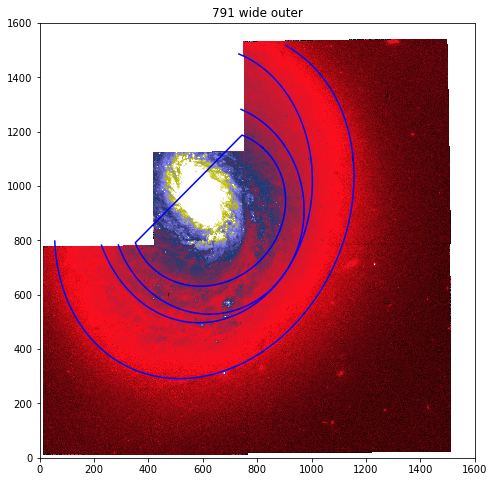

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(pixel_data_791, cmap=cm.gist_stern, vmin=0, vmax=400)
ax.set_xlim(limits)
ax.set_ylim(limits)
ax.set_title("791 wide outer")
for sma in [300.,400.,500.,700]:
    iso = w_list_outer.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    plt.plot(x, y, color='blue')

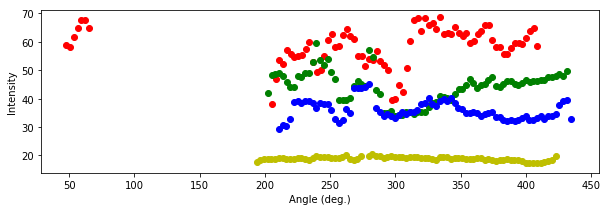

In [31]:
plt.figure(figsize=(10, 3))
plt.ylabel("Intensity")
plt.xlabel("Angle (deg.)")
for sma,color in zip([300.,400.,500.,700.],['r','g','b','y']):
    iso = w_list_outer.get_closest(sma)
    plt.scatter((iso.sample.values[0]+iso.sample.geometry.pa)/np.pi*180., iso.sample.values[2], color=color)